<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">

# Categorize German News Articles
Christph Fahrni, based on [RNN Text Classifier-Exercise](https://github.com/markif/2023_HS_DAS_NLP_Notebooks/blob/master/06_a_RNN_Text_Classifier.ipynb) by Joel Akeret and Fabian Märki

31.10.2023

## Approach 2: Fasttext and Bidirectional RNN
[Fasttext](https://fasttext.cc/) is an open-source library to convert text into a sequence of vectors. The created embeddings are quite smart, so synonymous expressions deal with a higher cosine similarity.
The bidirectional RNN is a recurrent neural network that itereates the tokens forward and backwards.

In this exercise the a bidirectional RNN/LSTM-model will be trained to classify [German news-articles](https://tblock.github.io/10kGNAD/) into 9 different categories: `Etat`, `Inland`, `International`, `Kultur`, `Panorama`, `Sport`, `Web`, `Wirtschaft`, `Wissenschaft`.

### Learnings
After extractng the 300 embeddings of each word I ran into memory issues. So I was not able to crated tensors because I was not using padding (to save memory). I tried to generate a ragged tensor, but it was processing for several minutes, so I stopped this approach. In the discussion with Joel, Joel suggested to do the conversion inside the upper part of the model. By using None as length of the embeddings, the model handels the variable length of the embeddings perfectly.
Additionally I was started mixing the pipeline with 'from the scratch'-code and the fhnw-library. Especially in the part with the embeddings this was not straightforward, so I decieded to follow the fhnw-library approach. This library is a very good inspiration also for my projects in the company.

The exercise is split into different steps, that are described in the table of content below:

### ToC
- Data preparation
  - Load dataset
  - Create tokens, visualize amount of tokens
  - Process tokens
- Setup environment
  - Prepare pipeline
  - Build the model
- Hyperparameter tuning
- Train the model using the identified parameters
- Evaluation
  - Inference test data
  - Confusion matrix
  - Scores, analysis

### Outlook
- Try to fine tune Embeddings
- Regalurisation: Tune optimal parameters for LSTM-Dropout.

## Summary
Goal: Predict the most probable category of the German news articles by doing the following Experiments:
- Hyperparameter tuning used to identfy the optimal LSTM parameters and learning rate.
- Model trained using optimzed parameters. Training causes overfitting the model.
- Evaluation of the model using test data.

The f1-score of 0.79 (average) is reached. On the category `Sport`, the f1-score is 0.97. Other categories like `Inland` and `Panorama` have a f1-score below 70%.

## Links

<a href="https://colab.research.google.com/github/markif/2023_HS_DAS_NLP_Notebooks/blob/master/06_a_RNN_Text_Classifier.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.colab import runs_on_colab

import pandas as pd
import numpy as np

set_log_level(2)
import tensorflow as tf

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.15.0-76-generic
Python version: 3.8.3
CPU cores: 16
RAM: 251.51GB total and 220.59GB available
Tensorflow version: 2.7.1
GPU is available


# Data preparation
* Download the dataset

In [3]:
%%time

file = "data/german_news_articles_original_train.parq"
download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
data_train = load_dataframe(file)

file = "data/german_news_articles_original_test.parq"
download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
data_test = load_dataframe(file)

print(data_train.shape)
print(data_test.shape)

(9245, 2)
(1028, 2)
CPU times: user 272 ms, sys: 77.3 ms, total: 349 ms
Wall time: 419 ms


* Mark as `train`/`test` datasets
* Get first impression of data

In [4]:
# remove all neutral sentimens
data_train["split"] = "train"
data_test["split"] = "test"
data_train.head(3)

,text_original,label,split
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,train
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,train
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,train


* Apply on `train`/`test` data:
    * Clean text: Remove html tags and other special characters
    * Tokenize text: Split text into tokens
    * Stem tokens
    * Crop to 512 tokens per article

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

nltk.download('punkt')# word_tokenize 
nltk.download('wordnet')
stop_words = set(stopwords.words("german"))
stemmer = SnowballStemmer("german")

MAX_TOKEN = 512

RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
RE_TAGS = re.compile(r"<[^>]+>")
RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

def clean_text(text):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
    """

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)
    return text

def create_tokens(text):
    text = text.lower()
    word_tokens = word_tokenize(text, language='german')
     # Removing Punctuation and Special Characters
    word_tokens = [word for word in word_tokens if word.isalnum()]
    # Stopword Removal
    word_tokens_sw = [word for word in word_tokens if word.lower() not in stop_words]
    word_stemmed = [stemmer.stem(word) for word in word_tokens_sw]
    return word_stemmed[:MAX_TOKEN] 
    

for data in[data_train, data_test]:
    data["text_clean"] = data["text_original"].map(clean_text)
    data["token_clean"] = data["text_clean"].map(create_tokens)
    data["word_num"] = data["token_clean"].str.len()   

[nltk_data] Downloading package punkt to /home/lcfa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lcfa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


* Show results after preparing tokens

In [13]:
data_test.head(5)

,text_original,label,split,text_clean,token_clean,word_num
0,"Die Gewerkschaft GPA-djp lanciert den ""All-in-...",Wirtschaft,test,Die Gewerkschaft GPA djp lanciert den All in R...,"[gewerkschaft, gpa, djp, lanciert, all, rechn,...",217
1,Franzosen verteidigen 2:1-Führung – Kritische ...,Sport,test,Franzosen verteidigen Führung Kritische Stimme...,"[franzos, verteid, fuhrung, kritisch, stimm, s...",365
2,Neues Video von Designern macht im Netz die Ru...,Web,test,Neues Video von Designern macht im Netz die Ru...,"[neu, video, design, macht, netz, rund, schlag...",192
3,23-jähriger Brasilianer muss vier Spiele pausi...,Sport,test,jähriger Brasilianer muss vier Spiele pausier...,"[jahrig, brasilian, vier, spiel, pausi, entsch...",229
4,Aufständische verwendeten Chemikalie bei Gefec...,International,test,Aufständische verwendeten Chemikalie bei Gefec...,"[aufstand, verwendet, chemikali, gefecht, augu...",85


## Visualize amount of tokens
* Distribution of the number of words: Chart found from: [link](https://www.kaggle.com/code/nikzzzn/lstm-nn-fasttext-embedding)
* The peak at the end is the result of cropping to 512 tokens.

/home/lcfa/nlp/env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


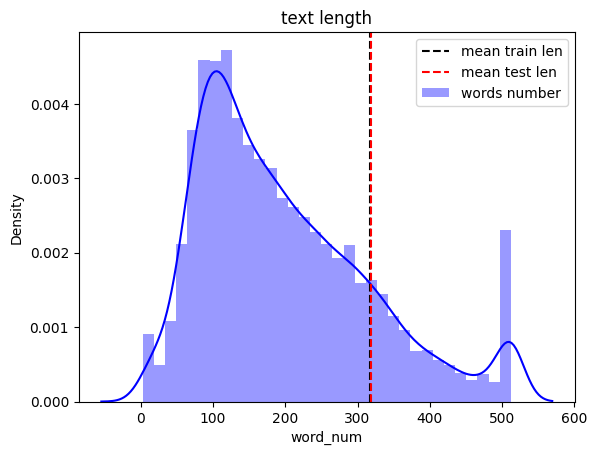

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
mean_len_train = np.round(data_train['word_num'].mean() + data_train['word_num'].std()).astype(int)
mean_len_test = np.round(data_test['word_num'].mean() + data_test['word_num'].std()).astype(int)
sns.distplot(data_train['word_num'], hist=True, kde=True, color='b', label='words number')
plt.axvline(x=mean_len_train, color='k', linestyle='--', label='mean train len')
plt.axvline(x=mean_len_test, color='r', linestyle='--', label='mean test len')
plt.title('text length'); plt.legend()
plt.show()

# Setup environment
## Prepare pipeline
* Import some helper functions...

In [15]:
from fhnw.nlp.utils.ploting import plot_history


from fhnw.nlp.utils.params import build_model_rnn
from fhnw.nlp.utils.params import build_preprocessed_dataset
from fhnw.nlp.utils.params import compile_model
from fhnw.nlp.utils.params import create_label_binarizer_and_set
from fhnw.nlp.utils.params import create_text_preprocessor
from fhnw.nlp.utils.params import dataframe_to_dataset
from fhnw.nlp.utils.params import extract_embedding_layer_and_set
from fhnw.nlp.utils.params import extract_text_vectorization_and_set
from fhnw.nlp.utils.params import extract_vocabulary_and_set
from fhnw.nlp.utils.params import get_train_test_split
from fhnw.nlp.utils.params import save_model

* Setup the *params* dictionary.
  * Fasttext (German), 300 embeddings

In [17]:
params = {
    "verbose": True,
    "shuffle": True,
    "n_samples": len(data),
    # modify batch_size in case you experience memory issues
    "batch_size": 128,
    "tokenized_column": "token_clean",
    "X_column_name": "text_clean",
    "y_column_name": "label",
    # modify to try different word embeddings
    "embedding_type": "fasttext",
    "embedding_dim": 300,
    "embedding_trainable": False,
    "embedding_fasttext_model": "cc.de.300.bin",
    # "embedding_word2vec_model_url": "https://cloud.devmount.de/d2bc5672c523b086/german.model",
    # "embedding_spacy_model": "de_core_news_md",
    # "embedding_tensorflow_hub_url": "https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2",
    "model_type": "rnn",
}

if runs_on_colab() and params["embedding_type"] == "fasttext":
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.switch.ch/index.php/s/fncH84BgISMlT3v/download", model_name)
    params["embedding_dim"] = 50
    params["embedding_fasttext_model"] = model_name
    

* extract the vocabulary

In [18]:
create_label_binarizer_and_set(params, data_train)
extract_vocabulary_and_set(params, data_train)

Inferred classification type: multi-class
Median sequence length: 170
Percentil (0.98) cutoff sequence length: 512
Max sequence length: 512
Used embedding sequence length: 512


* build the TextVectorization layer

In [19]:
extract_text_vectorization_and_set(params)

Vocabulary length: 34006


* Extract embeddings

In [21]:
%%time

extract_embedding_layer_and_set(params)

Embedding type: fasttext
Number of null word embeddings: 1
Words not found in total: 1
Words without embedding (1/1): ['']
CPU times: user 3.57 s, sys: 9.18 s, total: 12.7 s
Wall time: 12.7 s


* Prepare the `train`/`val`/`test` data

In [22]:
data_train_woVal, data_val = get_train_test_split(params, data_train)

dataset_train = dataframe_to_dataset(params, data_train_woVal)
dataset_test = dataframe_to_dataset(params, data_test)
dataset_val = dataframe_to_dataset(params, data_val)

7396 train examples
1849 test examples


In [300]:
for text, labels in dataset_train.take(2):
    print(text)
    print(labels)

tf.Tensor(b'Angreifer die Passwort kennen, k\xc3\xb6nnen sich ohne Problem per SSH einlogen Spurensuche l\xc3\xa4uft. Es kommt, wie es kommen musste Nur kurz nachdem zwei Hintert\xc3\xbcren in den Sicherheitsl\xc3\xb6sungen von Juniper bekannt wurden, werden diese jetzt aktiv ausgenutzt. Verwunderlich ist diese Entwicklung allerdings nicht Immerhin sind keine gro\xc3\x9fen technischen Skills notwendig, um einen solchen Angriff durchzuf\xc3\xbchren. Das Wissen \xc3\xbcber das mittlerweile \xc3\xb6ffentlich publizierte Master Passwort reicht aus, um sich auf einem System mit einer der verwundbaren Versionen von Junipers ScreenOS via SSH einzuloggen. Zudem gibt es mittlerweile nicht nur mehrere Scanner Programme, die gezielt nach der L\xc3\xbccke suchen, auch das Exploit Framework Metasploit soll schon bald ein entsprechendes Modul erhalten. Beim SANS Internet Storm Center hat man wiederum einen Honeypot mit einem verwundbaren Juniper Ger\xc3\xa4te aufgestellt, und so die laufenden Angrif

* Setup data pipeline

In [24]:
training_preprocessor = create_text_preprocessor(params, True)
dataset_train_preprocessed = build_preprocessed_dataset(params, dataset_train, True, training_preprocessor)
dataset_val_preprocessed = build_preprocessed_dataset(params, dataset_val, False, training_preprocessor)

## Build the model
* Labal binarizier: Fasttext model
* `Bidirectional` `LSTM` layer(s) with hyperparameter tuning:
    * hp_rnn_units: `LSTM` units 64, 96, 128
    * hp_rnn_depth: Additional RNN units 1..3
* GlobalMaxPooling
* Dense leyser with `sigmoid`-activation

Notes:
 * If depth is >0, the units are each halved
 * LSTM applies dropout of 30%

In [88]:
def build_model_rnn(params, hp):
    """Builds a rnn classifier (only partially) based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    from tensorflow import keras
    
    # choose the output activation function based on the classification type
    classification_type = params.get("classification_type", "binary")
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise TypeError("Unknown classification_type "+classification_type)
    
    X_column_name = params.get("X_column_name", "text_clean")
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"] # fasttext 
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1
    
    
    # Build a separate model for training
    model_train = keras.Sequential(name="rnn_train")
    # The input for the training model is already processes, i.e. vectorized.
    # Offloading this step and prefetching the data provides speedup during training 
    # After vectorization we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model_train.add(keras.Input(shape=(None,), dtype=tf.int64, name="preprocessed_input"))
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'. 
    model_train.add(embedding_layer)
    
    # build the RNN
    if hp == None:
        hp_rnn_units = 128
        hp_rnn_depth = 1
    else:
        hp_rnn_units = hp.Int('rnn_units', min_value=64, max_value=128, step=32)
        hp_rnn_depth = hp.Int('rnn_depth', min_value=0, max_value=3, step=1)

    rnn_units = hp_rnn_units
    for n in range(hp_rnn_depth):
        model_train.add(keras.layers.Bidirectional(
            keras.layers.LSTM(
                rnn_units, dropout= 0.3,
                return_sequences=True
            )
        ))
        rnn_units=int(rnn_units / 2)

    model_train.add(keras.layers.Bidirectional(
        keras.layers.LSTM(
            rnn_units, dropout= 0.3,
            return_sequences=True # needed since we do a GlobalMaxPool1D
        )
    ))
    
    # add global max pooling
    model_train.add(keras.layers.GlobalMaxPool1D(name="global_max_pool"))
    # add the classification head
    model_train.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))
    # Next we build the inference model that also contains the preprocessing (all in one)
    model_inference = keras.Sequential(name="rnn_inference")
    # A text input layer
    model_inference.add(keras.layers.InputLayer(input_shape=(1,), dtype=tf.string, name=X_column_name))
    # Then we vectorize the text.
    # After this layer, we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model_inference.add(vectorize_layer)
    # Next we just re-use the training model 
    model_inference.add(model_train)
    
    return model_train, model_inference

In [89]:
training_model, inference_model = build_model_rnn(params, None)

In [90]:
training_model.summary()

Model: "rnn_train"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         10201800  
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 256)        439296    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 global_max_pool (GlobalMaxP  (None, 128)              0         
 ooling1D)                                                       
                                                                 
 prediction (Dense)          (None, 9)                 1161      
                                                         

In [91]:
inference_model.summary()

Model: "rnn_inference"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 rnn_train (Sequential)      (None, 9)                 10806609  
                                                                 
Total params: 10,806,609
Trainable params: 604,809
Non-trainable params: 10,201,800
_________________________________________________________________


# Hyperparameter tuning
* Compile the model and start with hyperparameter tuning

In [73]:
# Helper function in params.py AttributeError: module 'keras.api._v2.keras.optimizers' has no attribute 'legacy'
# compile_model(params, training_model)

from tensorflow import keras
from fhnw.nlp.utils.params import get_model_metric
from fhnw.nlp.utils.params import get_loss_function

model_metric = get_model_metric(params)
model_loss_function = get_loss_function(params)

#model.compile(loss=model_loss_function, optimizer=adam, metrics=model_metric, jit_compile=True)
#training_model.compile(loss=model_loss_function, optimizer=adam, metrics=model_metric)

def model_builder(hp):
    training_model, inference_model = build_model_rnn(params, hp)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    adam = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    training_model.compile(loss=model_loss_function, optimizer=adam, metrics=model_metric)
    return training_model
    
#%pip install keras-tuner
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir_hp',
                     project_name='nlp_ft_rnn')

In [74]:
tuner.search(dataset_train_preprocessed,
        validation_data=dataset_val_preprocessed,
        epochs=30,
        callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=4)])

Trial 30 Complete [00h 03m 17s]
val_accuracy: 0.6452136039733887

Best val_accuracy So Far: 0.7820443511009216
Total elapsed time: 00h 56m 05s


In [82]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print('best hyperparameters')
print('rnn_units:     ', best_hps.get('rnn_units'))
print('rnn_depth:     ', best_hps.get('rnn_depth'))
print('learning_rate: ', best_hps.get('learning_rate'))

best hyperparameters
rnn_units:      128
rnn_depth:      1
learning_rate:  0.01


# Train the model using the identified parameters

In [81]:
params["training_epochs"] = 50
training_model = tuner.hypermodel.build(best_hps)
history = training_model.fit(
        dataset_train_preprocessed,
        validation_data=dataset_val_preprocessed,
        epochs=params["training_epochs"],
        shuffle=True,
        callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=4, restore_best_weights=True)])

Epoch 1/300
58/58 [==============================] - 33s 396ms/step - loss: 1.6189 - accuracy: 0.4133 - val_loss: 1.2187 - val_accuracy: 0.5598
Epoch 2/300
58/58 [==============================] - 17s 298ms/step - loss: 1.0680 - accuracy: 0.6275 - val_loss: 0.9605 - val_accuracy: 0.6755
Epoch 3/300
58/58 [==============================] - 17s 300ms/step - loss: 0.8668 - accuracy: 0.7094 - val_loss: 0.8750 - val_accuracy: 0.7025
Epoch 4/300
58/58 [==============================] - 17s 298ms/step - loss: 0.7538 - accuracy: 0.7393 - val_loss: 0.7599 - val_accuracy: 0.7447
Epoch 5/300
58/58 [==============================] - 17s 300ms/step - loss: 0.6297 - accuracy: 0.7888 - val_loss: 0.7274 - val_accuracy: 0.7545
Epoch 6/300
58/58 [==============================] - 17s 295ms/step - loss: 0.5712 - accuracy: 0.8068 - val_loss: 0.7275 - val_accuracy: 0.7501
Epoch 7/300
58/58 [==============================] - 17s 301ms/step - loss: 0.5200 - accuracy: 0.8231 - val_loss: 0.6981 - val_accuracy:

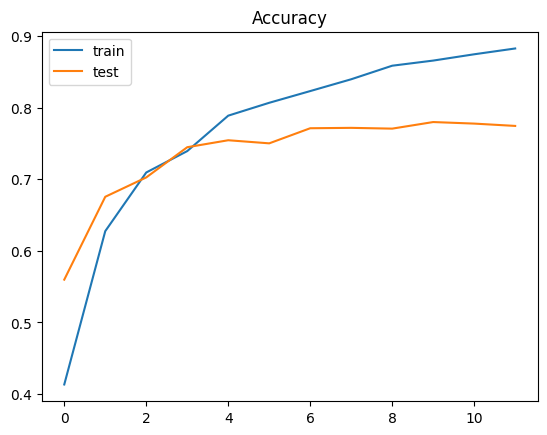

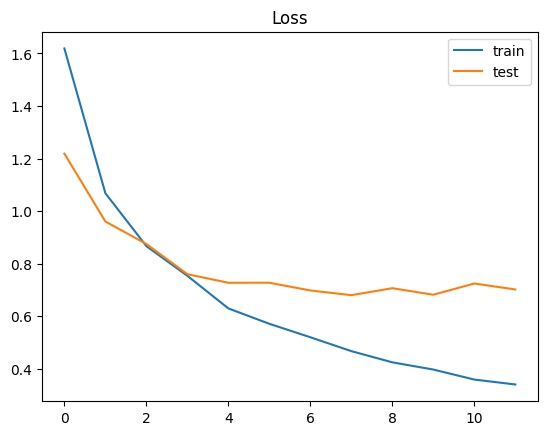

In [83]:
plot_history(history)

Validation accuracy: ~77%, epoch 8 recovered after early stopping.

Quite overfitted. Validation dosen't improve after significantelly ~3 epochs.

# Evaluation

In [84]:
from fhnw.nlp.utils.params import predict_classification
from fhnw.nlp.utils.ploting import report_classification_results

Set Population: 1028
Accuracy: 0.7928


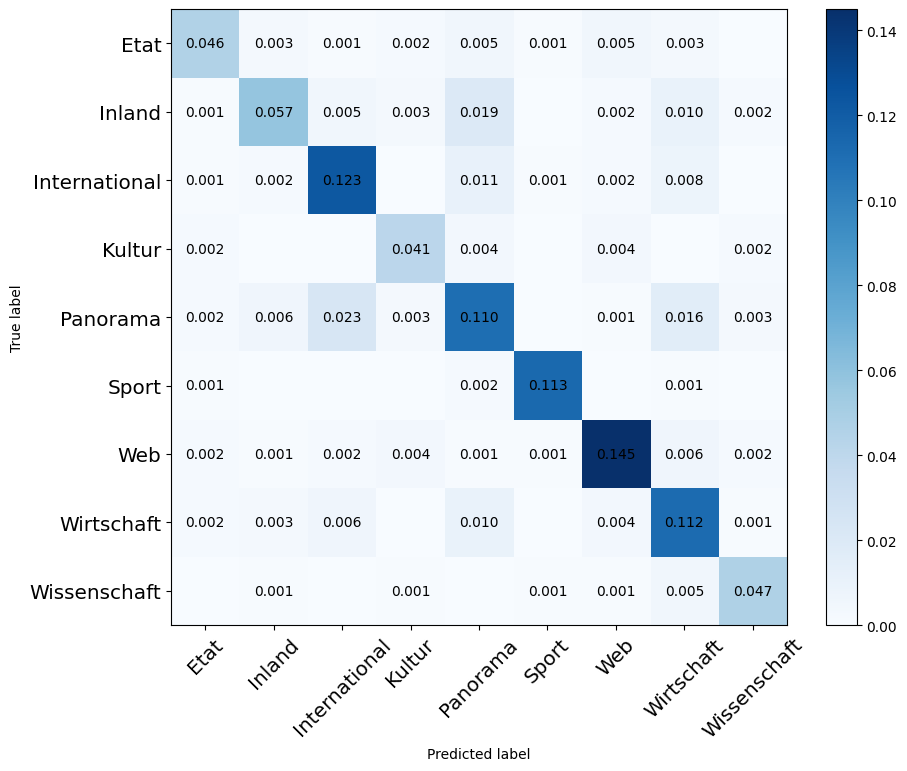

               precision    recall  f1-score   support

         Etat       0.81      0.70      0.75        67
       Inland       0.79      0.58      0.67       102
International       0.77      0.83      0.80       151
       Kultur       0.76      0.78      0.77        54
     Panorama       0.68      0.67      0.68       168
        Sport       0.97      0.97      0.97       120
          Web       0.89      0.89      0.89       168
   Wirtschaft       0.70      0.82      0.75       141
 Wissenschaft       0.83      0.84      0.83        57

     accuracy                           0.79      1028
    macro avg       0.80      0.79      0.79      1028
 weighted avg       0.79      0.79      0.79      1028

CPU times: user 1.92 s, sys: 236 ms, total: 2.15 s
Wall time: 1.73 s


In [86]:
%%time

preprocessor = create_text_preprocessor(params, False)
y, y_pred, y_pred_prob = predict_classification(params, data_test, training_model, preprocessor)
report_classification_results(params, y, y_pred)

## Analysis of the results
* f1-accuracy: 79% (Approach1 with Bert got 88%)
* class with highest f1-score: `Sport` (97%)
* class with lowest f1-score:  `Inland` (67%), follewed by `Panorama` (68%)

Articles from category `Inland` are often predicted as `Panorama`. `Panorama` is often predicted as `International`.